# Curso Computer Vision

<img src="https://yaelmanuel.com/wp-content/uploads/2021/12/platzi-banner-logo-matematicas.png" width="500px">

---

**Instalar dependencias**

In [ ]:
!pip3 install ultralytics

**Descargar el modelo de Yolo manualmente**

In [ ]:
# !wget https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n-seg.pt

**Definir el path del vídeo**

In [ ]:
video_path = "/content/store-aisle-detection.mp4"

In [8]:
video_path = "/content/park_detection.avi"

**Arrancar el proceso**

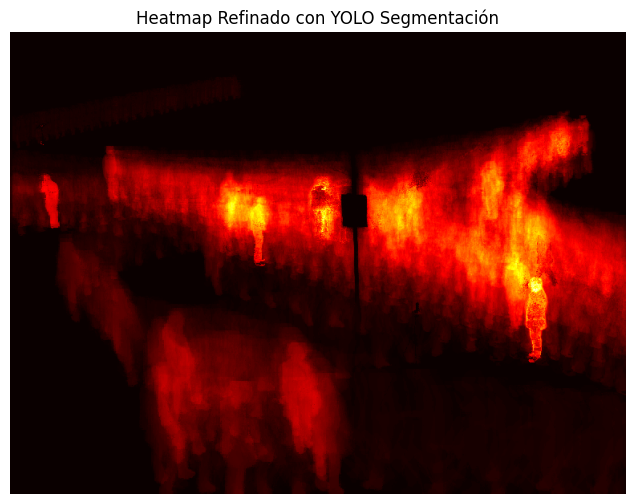

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO


# Abrir el video
cap = cv2.VideoCapture(video_path)

# Crear sustractor de fondo
bg_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=500,          # Número de frames usados para construir el fondo.
    varThreshold=16,      # Sensibilidad para detectar cambios
    detectShadows=True,   # Detección de sombras
    )

heatmap_refined = None

# Cargar el modelo YOLOv11 para segmentación
model = YOLO("yolo11n-seg")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Inicializar el acumulador del heatmap en el primer frame
    if heatmap_refined is None:
        heatmap_refined = np.zeros(frame.shape[:2], dtype=np.float32)

    # --- Paso 1: Sustracción de Fondo ---
    fgmask = bg_subtractor.apply(frame)
    # Umbral para obtener una máscara binaria limpia
    _, fgmask = cv2.threshold(fgmask, 200, 255, cv2.THRESH_BINARY)

    # --- Paso 2: Segmentación con YOLO ---
    # Realizamos la detección con segmentación sobre el frame completo.
    results = model(frame, verbose=False)[0]

    # Crear una máscara vacía para acumular las segmentaciones de la clase "persona"
    segmentation_mask = np.zeros(frame.shape[:2], dtype=np.uint8)

    if results.masks is not None:
        # Extraer las máscaras y las clases
        masks = results.masks.data.cpu().numpy() if hasattr(results.masks.data, 'cpu') else results.masks.data
        classes = results.boxes.cls.cpu().numpy() if hasattr(results.boxes.cls, 'cpu') else results.boxes.cls

        for mask, cls in zip(masks, classes):
            if int(cls) == 0:  # Filtramos detecciones de persona (en COCO, "person" es la clase 0)
                mask_bin = (mask > 0.5).astype(np.uint8) * 255
                # Redimensionar mask_bin a las dimensiones del frame (o segmentation_mask)
                mask_bin_resized = cv2.resize(mask_bin, (segmentation_mask.shape[1], segmentation_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
                segmentation_mask = cv2.bitwise_or(segmentation_mask, mask_bin_resized)

    # --- Paso 3: Combinación de Máscaras ---
    # Se realiza una intersección entre la máscara de movimiento y la máscara de segmentación de personas
    refined_mask = cv2.bitwise_and(fgmask, segmentation_mask)

    # Acumulamos la máscara refinada en el heatmap
    heatmap_refined = cv2.add(heatmap_refined, refined_mask.astype(np.float32))

# Visualización final del heatmap refinado
plt.figure(figsize=(8,6))
plt.imshow(heatmap_refined, cmap='hot')
plt.title("Heatmap Refinado con YOLO Segmentación")
plt.axis('off')
plt.show()


**Heatmap normalizado**

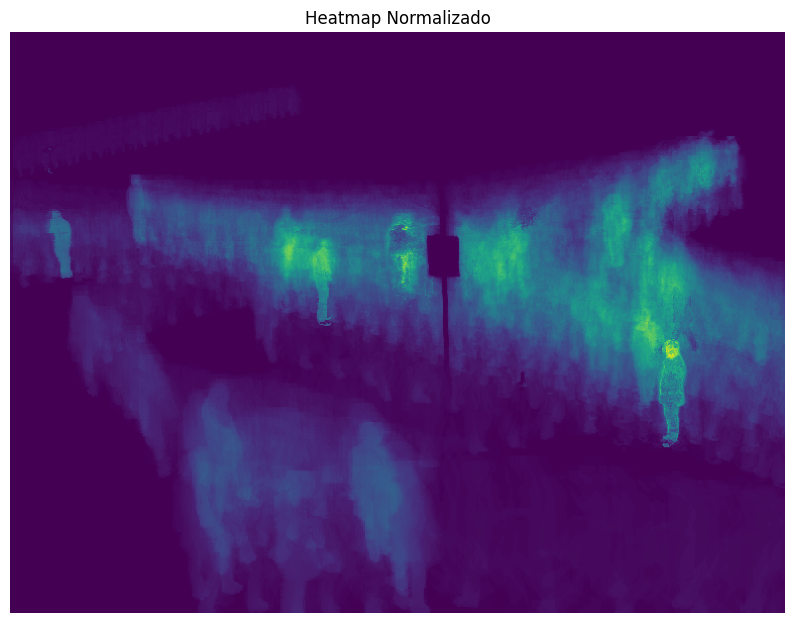

In [10]:
# Normalizar el heatmap a rango 0-255
heatmap_norm = cv2.normalize(heatmap_refined, None, 0, 255, cv2.NORM_MINMAX)
heatmap_norm = np.uint8(heatmap_norm)

# Aplicar un colormap (por ejemplo, COLORMAP_VIRIDIS)
colored_heatmap = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_VIRIDIS)

# Visualización con matplotlib
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(colored_heatmap, cv2.COLOR_BGR2RGB))
plt.title("Heatmap Normalizado")
plt.axis("off")
plt.show()